In [1]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
import nbimporter
from tt_class1 import TrafficDataAnalysis
import csv
import os
import sys
import warnings
warnings.filterwarnings("ignore")

In [27]:
pip show nbimporter

Name: nbimporter
Version: 0.3.4
Summary: Import IPython notebooks as modules
Home-page: https://github.com/grst/nbimporter
Author: Gregor Sturm
Author-email: mail@gregor-sturm.de
License: BSD 3-clause
Location: /opt/anaconda3/lib/python3.11/site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
es = Elasticsearch('https://127.0.0.1:9200',verify_certs = False,basic_auth = ('elastic', 'elastic'),request_timeout=300)

In [6]:
#从vic_roads_crash里读取事件类型，周几，地点和区名
scroll = es.search(
    index="vic_roads_crash",
    scroll='2m',  
    size=100,  
    body={
        "query": {
            "match_all": {}
        },
        "_source": ["ACCIDENT_TYPE", "DAY_OF_WEEK", "Location", "LGA_NAME"]
    }
)


all_crash_data = []


while True:
   
    scroll_id = scroll['_scroll_id']
    hits = scroll['hits']['hits']
    
    if not hits:
        break
    
    all_crash_data.extend(hits)
    
    scroll = es.scroll(scroll_id=scroll_id, scroll='2m')

es.clear_scroll(scroll_id=scroll_id)

print(f"The total number of results retrieved: {len(all_crash_data)}")

The total number of results retrieved: 78585


In [7]:
#traffic_volume中获取车流量，coordinates,OBJECTID
scroll = es.search(
    index="traffic_volume",
    scroll='2m',
    size=200,
    body={
        "query": {"match_all": {}},
        "_source": ["ALLVEHS_MMW", "coordinates", "OBJECTID"]
    }
)

all_traffic_data = []

while True:
    scroll_id = scroll['_scroll_id']
    hits = scroll['hits']['hits']
    if not hits:
        break
    all_traffic_data.extend(hits)
    scroll = es.scroll(scroll_id=scroll_id, scroll='2m')

es.clear_scroll(scroll_id=scroll_id)

print("Total number of records retrieved:", len(all_traffic_data))

Total number of records retrieved: 14666


In [8]:
traffic_volume = {}
for road in all_traffic_data:
    object_id = road['_source']['OBJECTID']
    all_vehs_mmw = road['_source']['ALLVEHS_MMW']
    traffic_volume[object_id] = all_vehs_mmw

In [10]:
analysis = TrafficDataAnalysis(all_traffic_data, all_crash_data)
analysis.analyze_accidents()

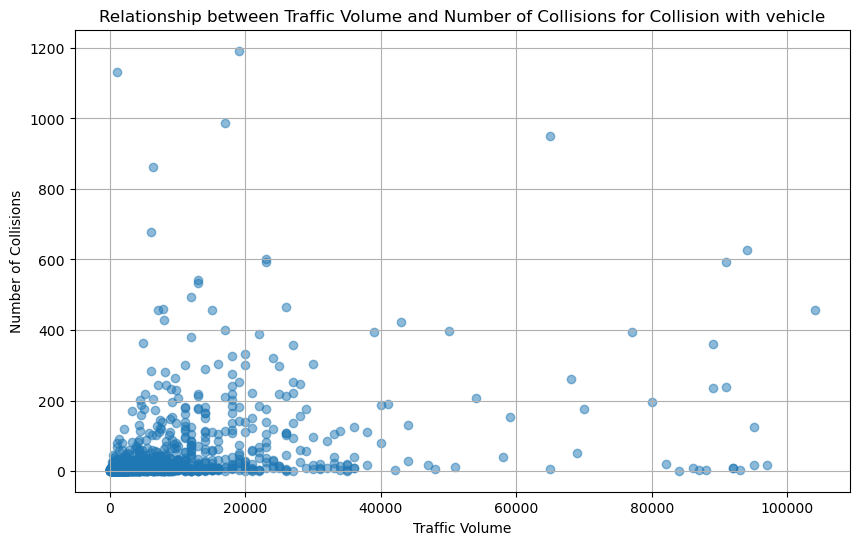

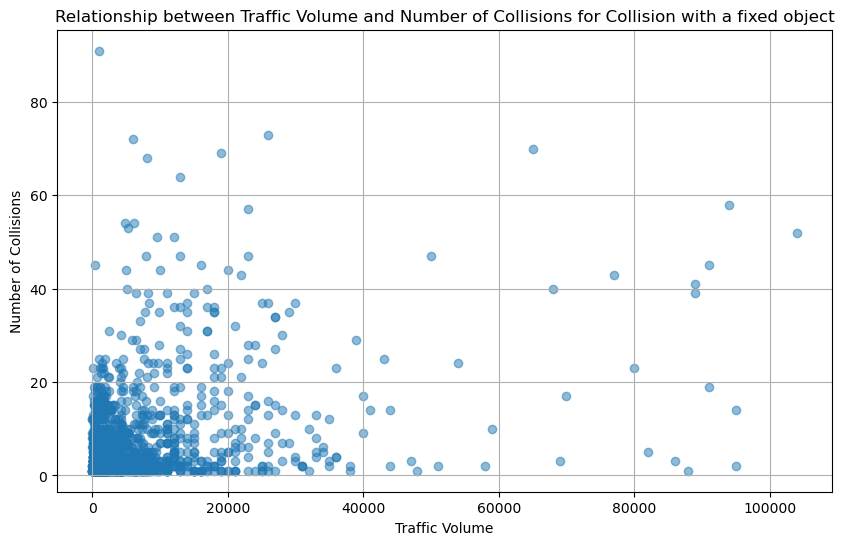

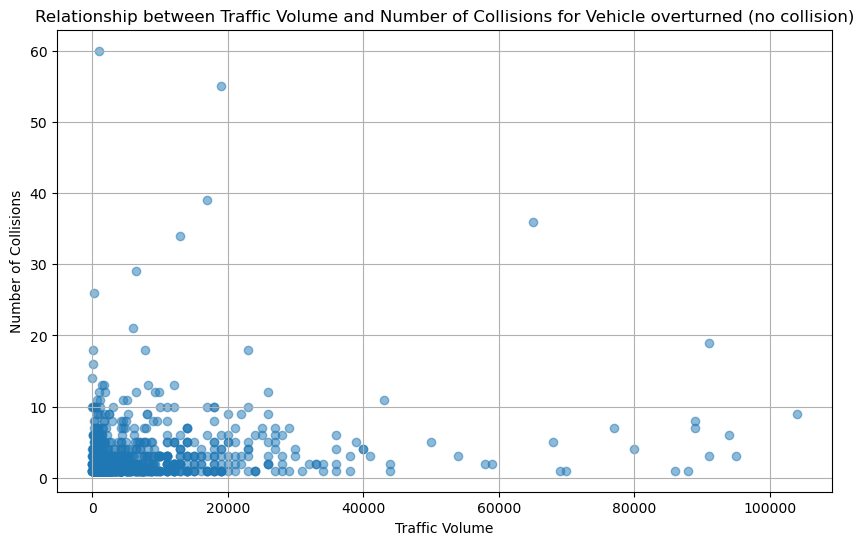

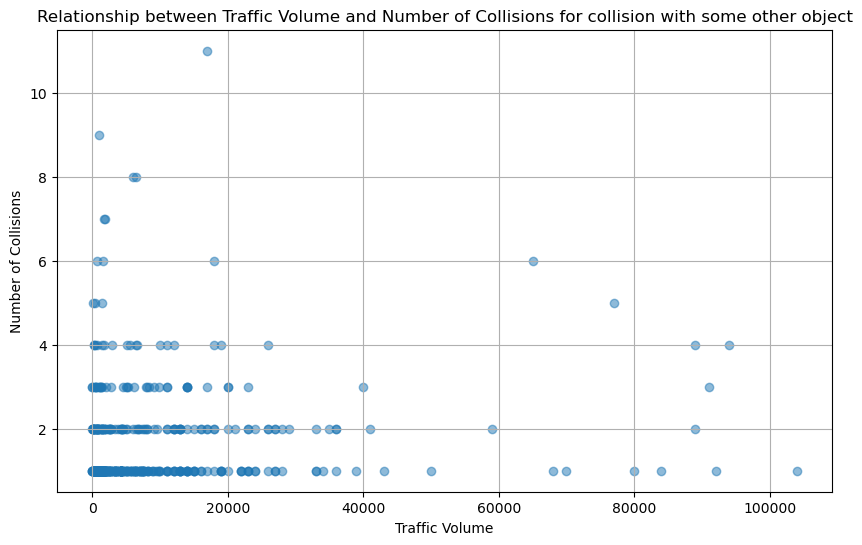

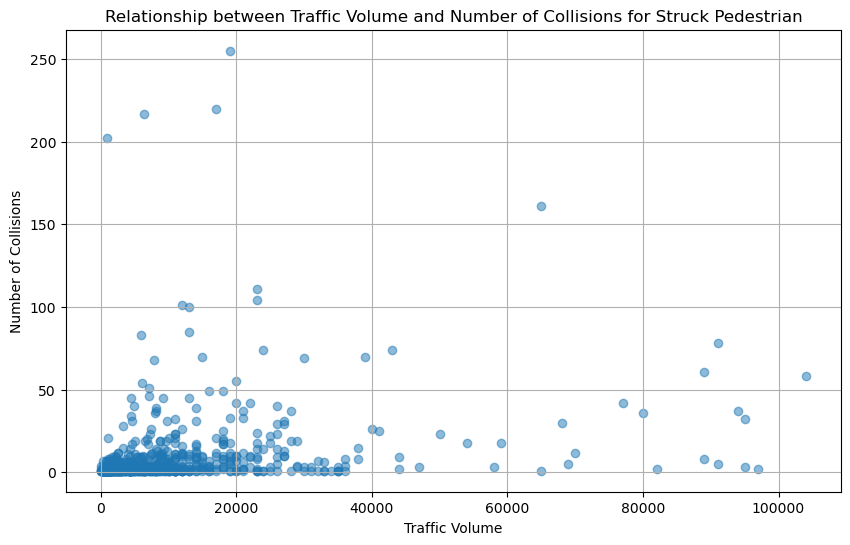

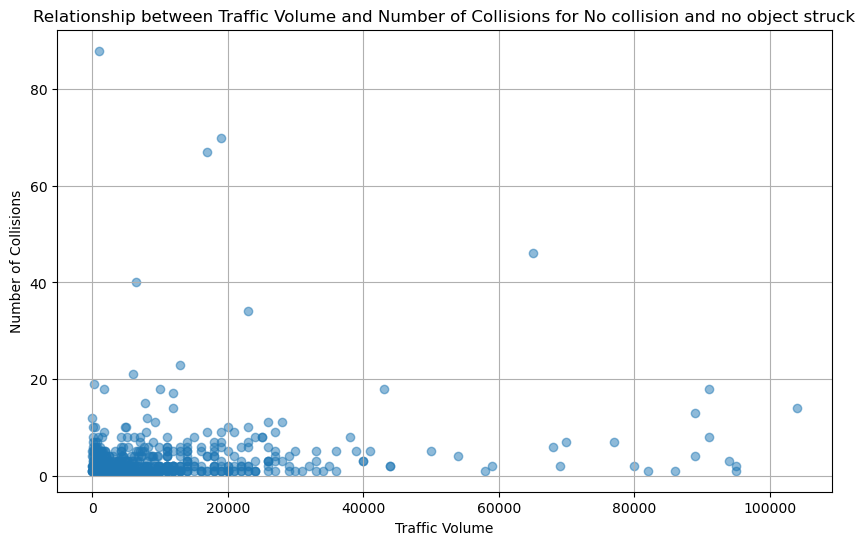

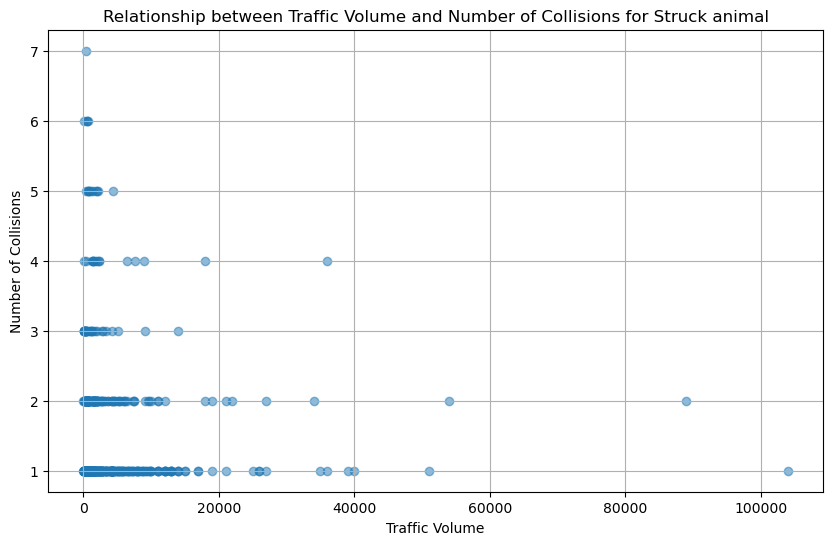

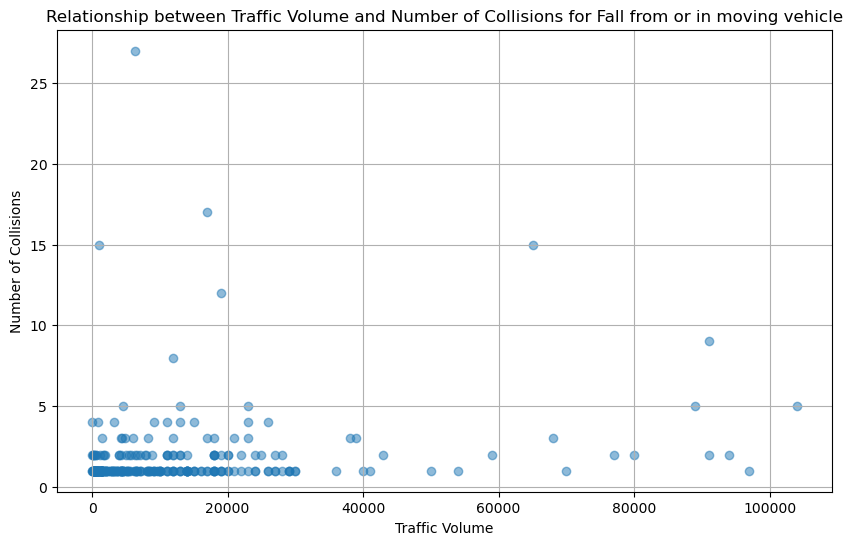

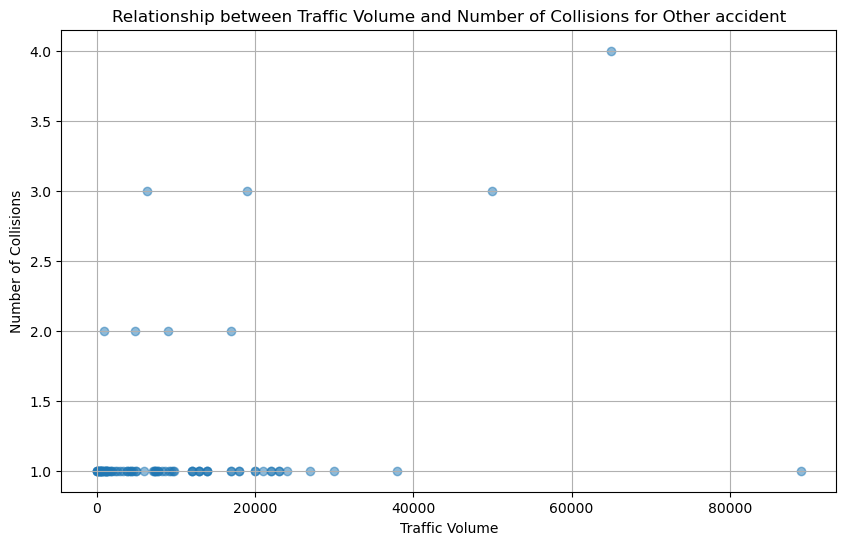

In [11]:
analysis.plot_collisions()